### Anomaly Detection
This project aims to design a model to detect anomalies in credit card transaction data. The data is sourced from Kaggle. 

Anomaly detection model training faces a problem that anomalies in orignal dataset usually takes up little proportion, resulting in insufficient positive data for the model to learn and unsatisfying model performance. In this project, I used undersampling and oversampling to deal with this problem and compared their outcomes.

In this project, I tried logistic regression, knn, decision tree, and auto-encoder, totally four algorithms, and compared their performance in order to build the best detection model out of them. Recall, F-score, precision-recall curve and AUC were applied to evaluate model performance.

In [8]:
import pandas as pd
import numpy as np
 
#from sklearn import LogisticRegression, RandomForest, KNearestNeighbor
#import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [231]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix

#### 1. Read in data

In [2]:
df = pd.read_csv('creditcard.csv')

In [254]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [4]:
df.shape

(284807, 31)

#### 2. Data Exploratory Analysis

1. Data cleaning: any null cells
2. Data class distribution

In [5]:
df.isnull().sum().max()

0

In [33]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Normal = 99.83%
Fraud = 0.17%


Text(0, 0.5, 'Frequency')

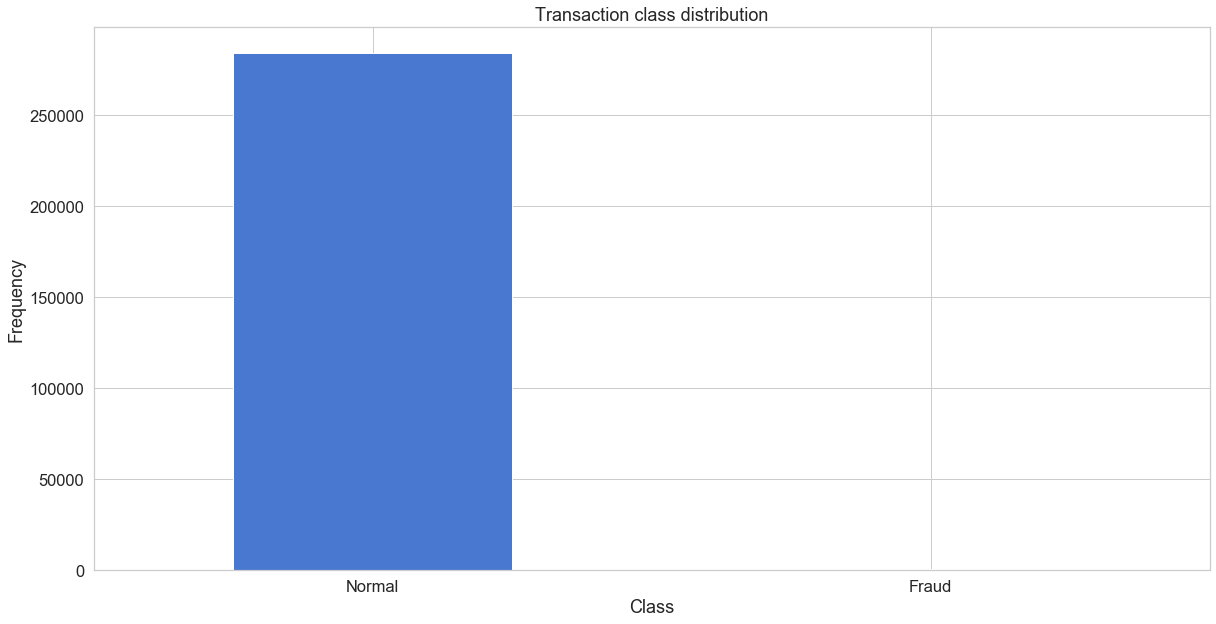

In [45]:
print ('Normal = {}%'.format(round(df['Class'].value_counts()[0]/df.shape[0]*100, 2)))
print ('Fraud = {}%'.format(round(df['Class'].value_counts()[1]/df.shape[0]*100, 2)))

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.figure(figsize=(20,10))

count_class = df.groupby('Class')['Time'].count()
count_class.plot(kind='bar', rot=0)

plt.title("Transaction class distribution")
plt.xticks([0,1], ['Normal', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Frequency')

More than 99% of the transaction data are normal, and the model we are about to build will probably get a lot of errors in prediction if we use the original imbalanced dataset to train it.

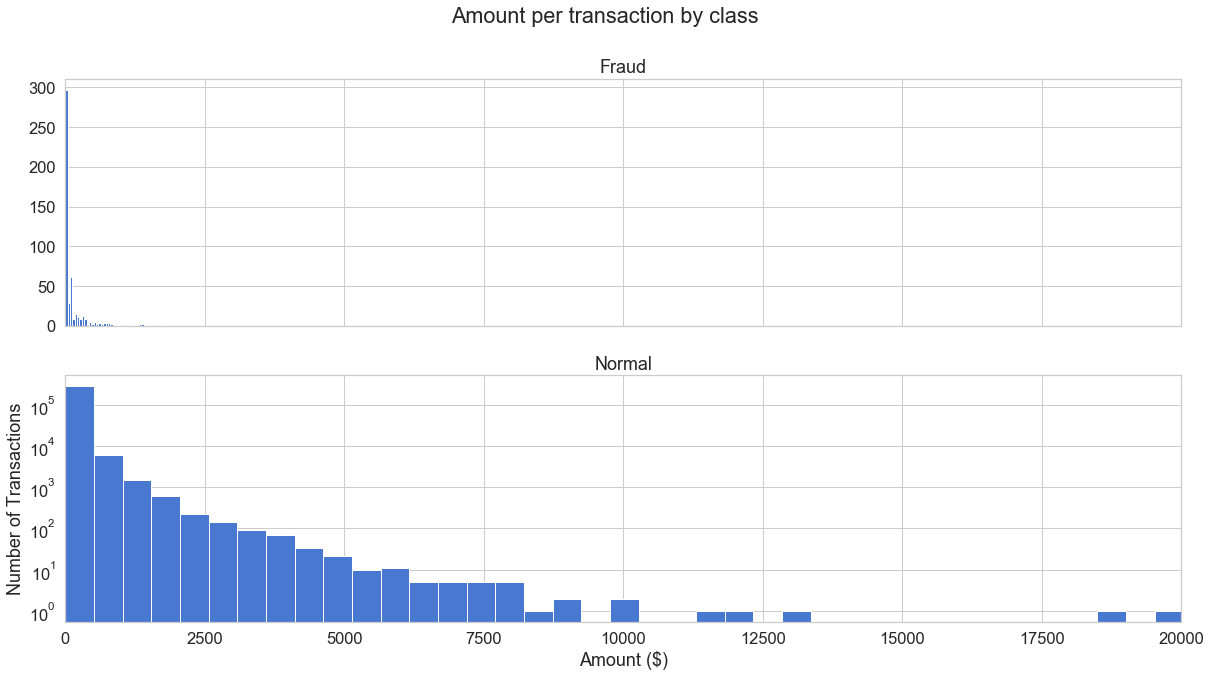

In [49]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)

f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

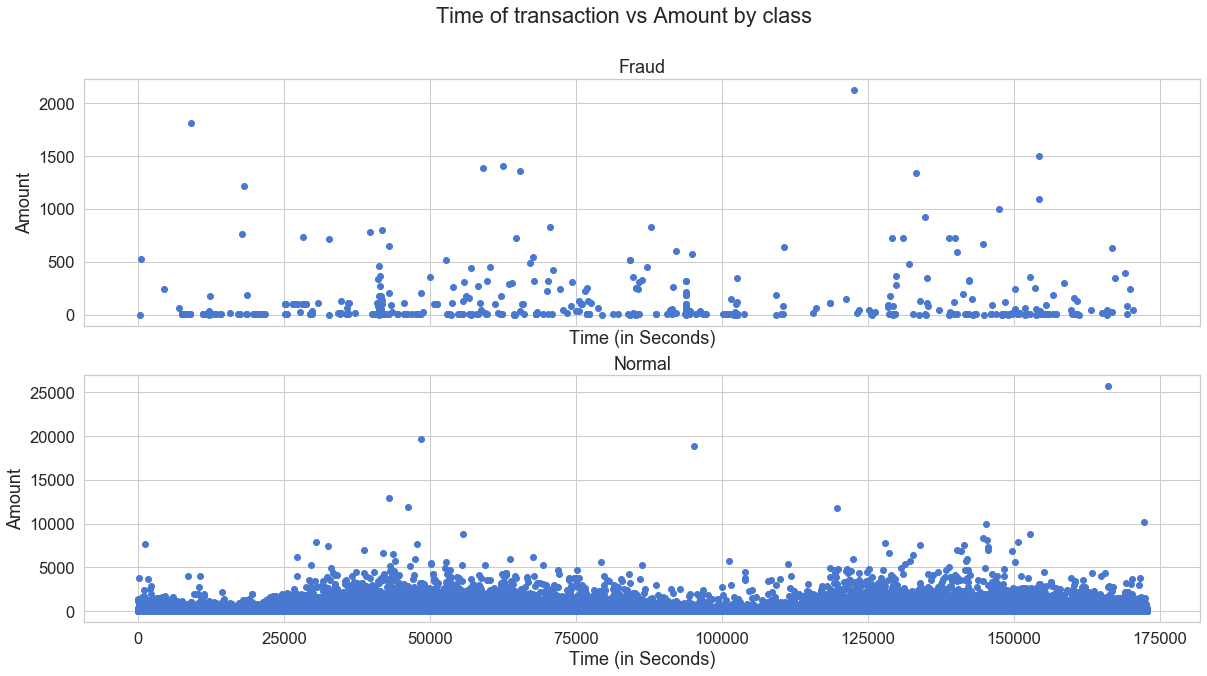

In [52]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax1.set_xlabel('Time (in Seconds)')
ax1.set_ylabel('Amount')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
ax2.set_xlabel('Time (in Seconds)')
ax2.set_ylabel('Amount')
plt.show()

From the plots above, fraud transaction generally has small amount. In terms of distribution of amount versus time, there is no obvious shape difference between fraud and normal transaction.

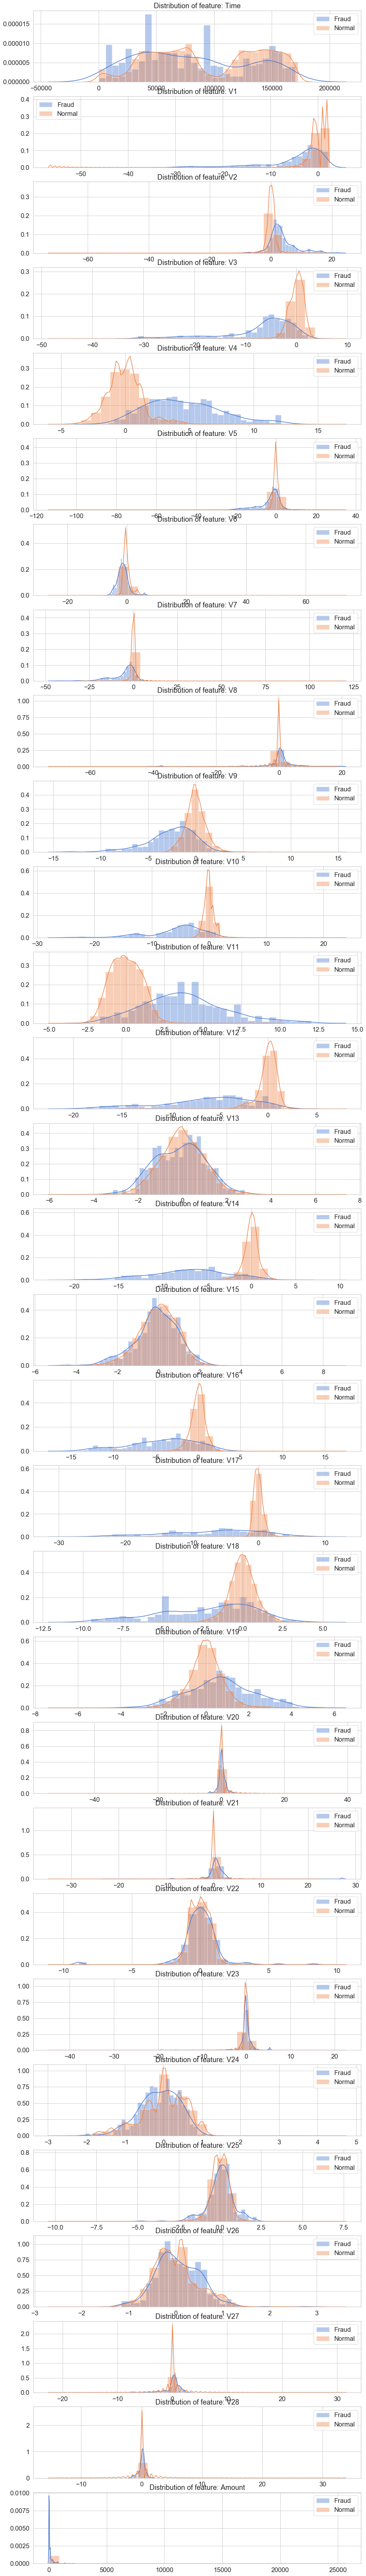

In [55]:
import matplotlib.gridspec as gridspec

X = df[df.columns[df.columns != 'Class']]
y = df.Class
features=[f for f in df.columns if f!='Class']
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X[feat][y==1], bins=30)
    sns.distplot(X[feat][y==0],bins=30)
    ax.legend(['Fraud', 'Normal'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

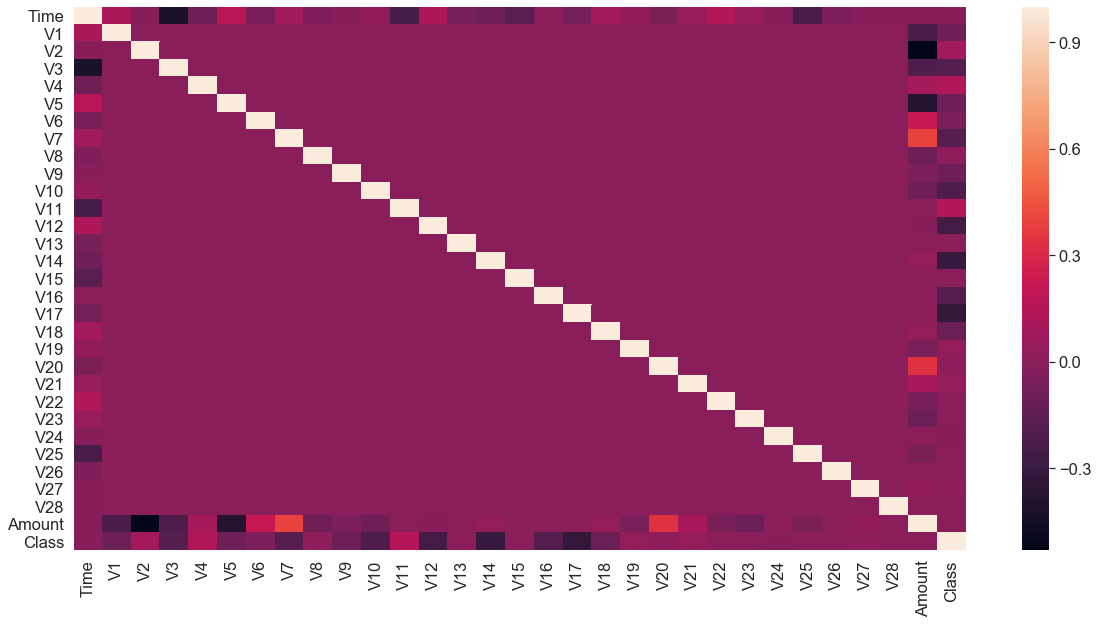

In [61]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot_kws={'size': 10})

As clarified on the data source page that the original features in dataset were generated and selected by PCA, we do not perform feature engineering further.

#### 3. Sampling data
 - undersampling the majority class
 - oversampling the minority class

In [67]:
import imblearn
from sklearn.preprocessing import StandardScaler

In [99]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
X = df.drop(['Class','Time'], axis=1)
y = df['Class']

In [316]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=50)

In [101]:
print (ytrain.value_counts())
print (ytest.value_counts())

0    199019
1       345
Name: Class, dtype: int64
0    85296
1      147
Name: Class, dtype: int64


#### 4. Logistic Regression

In [257]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve

##### Undersampling

In [103]:
# Split the training set into 10 folds for cross validation 
kfold = StratifiedKFold(n_splits=10)
rus = RandomUnderSampler(random_state=42)
LR = LogisticRegression()
recall = []
fscore = []
np_idx = 0

for train_idx, valid_idx in kfold.split(Xtrain, ytrain):
    X_train, X_valid = Xtrain.values[train_idx], Xtrain.values[valid_idx]
    y_train, y_valid = ytrain.values[train_idx], ytrain.values[valid_idx]
    
    X_re, y_re = rus.fit_resample(X_train, y_train)   #undersampling data
    
    LR.fit(X_re, y_re)     #fit data to the model
    
    y_pred = LR.predict(X_valid)
    
    rec = recall_score(y_valid, y_pred)
    f = f1_score(y_valid, y_pred)
    recall.append(rec) 
    fscore.append(f)
    np_idx += 1
    
    print ("Fold {}: Recall: {} F1-Score: {}".format(np_idx, round(rec,3), round(f, 3)))      #round to 3-digit float

print ("Average Recall: {}".format(round(np.mean(recall),3)))   #print average recall and f-score 
print ("Average F1-Score: {}".format(round(np.mean(fscore),3)))

Fold 1: Recall: 0.943 F1-Score: 0.056
Fold 2: Recall: 0.914 F1-Score: 0.053
Fold 3: Recall: 0.971 F1-Score: 0.061
Fold 4: Recall: 0.943 F1-Score: 0.065
Fold 5: Recall: 0.882 F1-Score: 0.058
Fold 6: Recall: 0.912 F1-Score: 0.069
Fold 7: Recall: 0.882 F1-Score: 0.061
Fold 8: Recall: 0.912 F1-Score: 0.068
Fold 9: Recall: 0.853 F1-Score: 0.063
Fold 10: Recall: 0.886 F1-Score: 0.059
Average Recall: 0.91
Average F1-Score: 0.061


In [349]:
rus = RandomUnderSampler(random_state=42)
X_re, y_re = rus.fit_resample(Xtrain, ytrain)
LR_u = LogisticRegression()

LR_u.fit(X_re, y_re)

y_pred = LR_u.predict(Xtest)
rec_lr_u = recall_score(ytest, y_pred)
f_lr_u = f1_score(ytest, y_pred)

print ("Recall: {}".format(round(rec_lr_u,3)))
print ("F-score: {}".format(round(f_lr_u,3)))

Recall: 0.925
F-score: 0.091


In [348]:
y_prob = LR_u.predict_proba(Xtest)

pred_lr_u = pd.DataFrame({'prob':y_prob[:,1], 'Class':ytest})

No handles with labels found to put in legend.


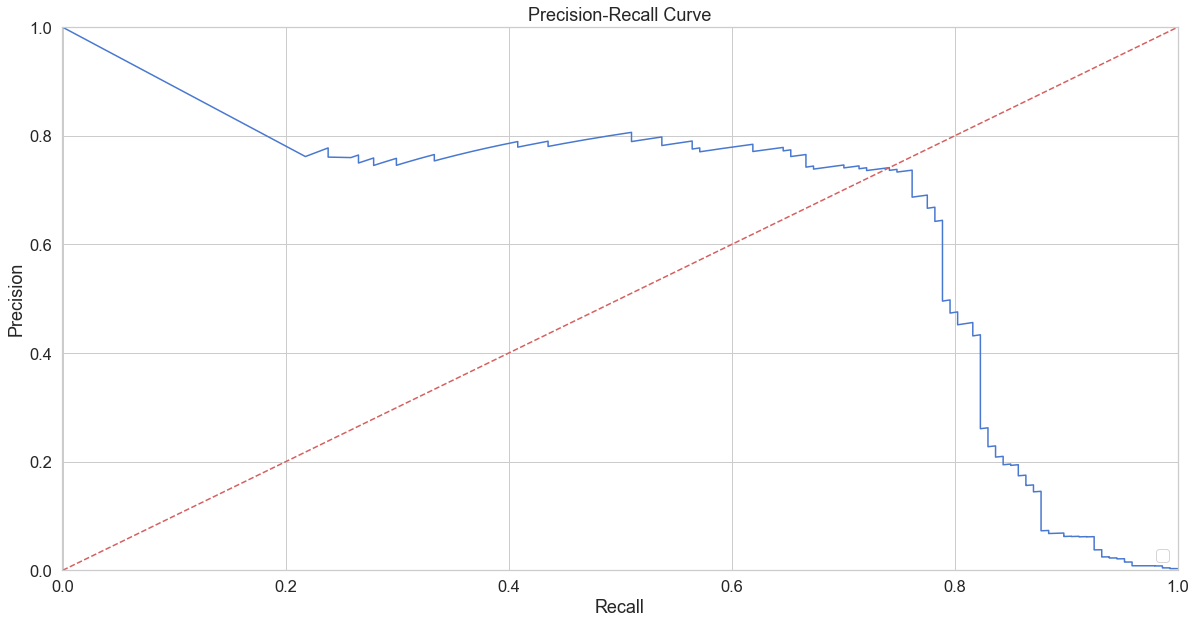

In [262]:
precision, recall, thresholds = precision_recall_curve(pred_lr_u.Class, pred_lr_u.prob)

plt.figure(figsize=(20,10))
plt.title('Precision-Recall Curve')
plt.plot(recall, precision)
#plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

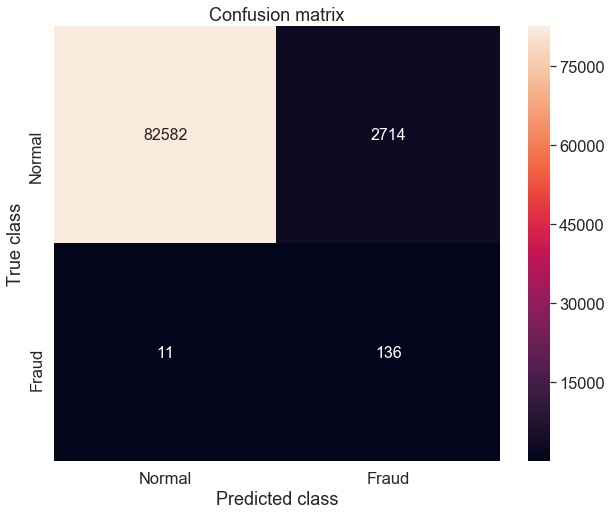

In [350]:
conf_matrix = confusion_matrix(pred_lr_u.Class, y_pred,labels=np.unique(pred_lr_u.Class))
cm = pd.DataFrame(conf_matrix, index=np.unique(pred_lr_u.Class), columns=np.unique(pred_lr_u.Class))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d",annot_kws={"size": 16});
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

##### Oversampling

In [109]:
from imblearn.over_sampling import SMOTE

In [111]:
kfold = StratifiedKFold(n_splits=10)
smote = SMOTE(random_state=42)
LR = LogisticRegression()
recall = []
fscore = []
np_idx = 0

for train_idx, valid_idx in kfold.split(Xtrain, ytrain):
    X_train, X_valid = Xtrain.values[train_idx], Xtrain.values[valid_idx]
    y_train, y_valid = ytrain.values[train_idx], ytrain.values[valid_idx]
    
    X_re, y_re = smote.fit_resample(X_train, y_train)   #undersampling data
    
    LR.fit(X_re, y_re)     #fit data to the model
    
    y_pred = LR.predict(X_valid)
    
    rec = recall_score(y_valid, y_pred)
    f = f1_score(y_valid, y_pred)
    recall.append(rec) 
    fscore.append(f)
    np_idx += 1
    
    print ("Fold {}: Recall: {} F1-Score: {}".format(np_idx, round(rec,3), round(f, 3)))      #round to 3-digit float

print ("Average Recall: {}".format(round(np.mean(recall),3)))   #print average recall and f-score 
print ("Average F1-Score: {}".format(round(np.mean(fscore),3)))

Fold 1: Recall: 0.914 F1-Score: 0.108
Fold 2: Recall: 0.914 F1-Score: 0.117
Fold 3: Recall: 0.971 F1-Score: 0.115
Fold 4: Recall: 0.943 F1-Score: 0.114


C:\Users\yuzij\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Fold 5: Recall: 0.853 F1-Score: 0.103
Fold 6: Recall: 0.912 F1-Score: 0.126
Fold 7: Recall: 0.882 F1-Score: 0.113
Fold 8: Recall: 0.912 F1-Score: 0.117
Fold 9: Recall: 0.824 F1-Score: 0.104
Fold 10: Recall: 0.857 F1-Score: 0.101
Average Recall: 0.898
Average F1-Score: 0.112


Warning of iteration limit occured when model training used oversampling data.

Then try Grid Search for hyperparameter tuning to optimize logistic regression model.

In [292]:
param = {'C' :[0.001, 0.01, 0.1, 1, 10, 100]}

In [301]:
smote = SMOTE(random_state=42)
X_re, y_re = smote.fit_resample(Xtrain, ytrain)

LR = LogisticRegression()
gsc = GridSearchCV(LR, param, scoring='f1')

In [302]:
gsc.fit(X_re, y_re)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]}, scoring='f1')

In [303]:
gsc.best_params_

{'C': 10}

In [351]:
smote = SMOTE(random_state=42)
X_re, y_re = smote.fit_resample(Xtrain, ytrain)
LR_sm = LogisticRegression(C=10)

LR_sm.fit(X_re, y_re)

y_pred = LR_sm.predict(Xtest)
rec_lr_sm = recall_score(ytest, y_pred)
f_lr_sm = f1_score(ytest, y_pred)

print ("Recall: {}".format(round(rec_lr_sm,3)))
print ("F-score: {}".format(round(f_lr_sm,3)))

Recall: 0.905
F-score: 0.116


In [311]:
y_prob = LR_sm.predict_proba(Xtest)

pred_lr_sm = pd.DataFrame({'prob':y_prob[:,1], 'Class':ytest})

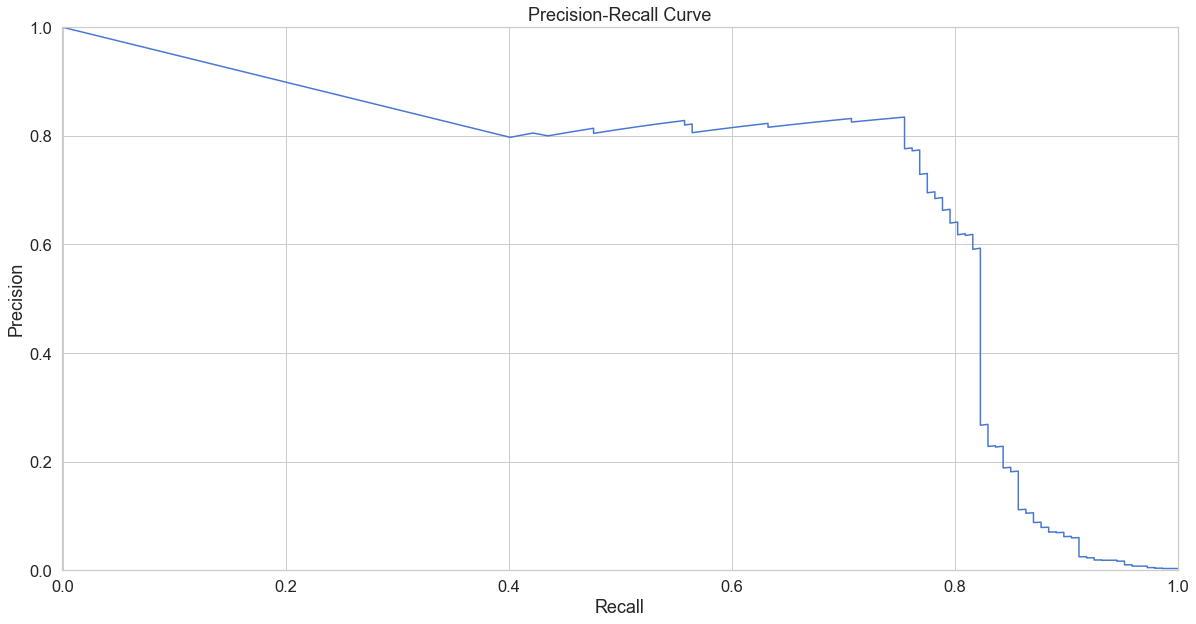

In [338]:
precision, recall, thresholds = precision_recall_curve(pred_lr_sm.Class, pred_lr_sm.prob)

plt.figure(figsize=(20,10))
plt.title('Precision-Recall Curve')
plt.plot(recall, precision)
#plt.legend(loc='lower right')
#plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

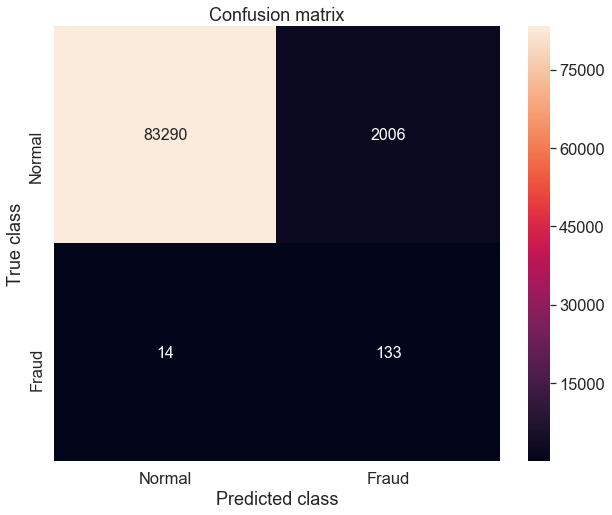

In [352]:
conf_matrix = confusion_matrix(pred_lr_sm.Class, y_pred,labels=np.unique(pred_lr_sm.Class))
cm = pd.DataFrame(conf_matrix, index=np.unique(pred_lr_sm.Class), columns=np.unique(pred_lr_sm.Class))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d",annot_kws={"size": 16});
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Undersampling produces higher AUC while oversampling produces higher recall.


#### 5. KNN

In [107]:
from sklearn.neighbors import KNeighborsClassifier

Cross validation is not applied to KNN training since KNN training needs much more computation and time than logistic regression. My laptop crashed several times trying to run multiple KNN training. I would like to try cross validation on KNN performance if I have a computer with high RAM.

##### Undersampling

In [113]:
rus = RandomUnderSampler(random_state=42)
X_re, y_re = rus.fit_resample(Xtrain, ytrain)

for i in [10, 20, 30, 40]:
    
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_re, y_re)

    y_pred = knn.predict(Xtest)
    rec = recall_score(ytest, y_pred)
    f = f1_score(ytest, y_pred)

    print ("n_neighbors: {} Recall: {} F-score: {}".format(i, round(rec,3), round(f,3)))
    

n_neighbors: 10 Recall: 0.864 F-score: 0.214
n_neighbors: 20 Recall: 0.864 F-score: 0.24
n_neighbors: 30 Recall: 0.857 F-score: 0.254
n_neighbors: 40 Recall: 0.857 F-score: 0.289


In [354]:
rus = RandomUnderSampler(random_state=42)
X_re, y_re = rus.fit_resample(Xtrain, ytrain)
for i in [50, 100, 150, 200]:
    
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_re, y_re)

    y_pred = knn.predict(Xtest)
    rec = recall_score(ytest, y_pred)
    pre = precision_score(ytest, y_pred)
    f = f1_score(ytest, y_pred)

    print ("n_neighbors: {} Precision: {} Recall: {} F-score: {}".format(i, round(pre, 3), round(rec,3), round(f,3)))

n_neighbors: 50 Precision: 0.234 Recall: 0.837 F-score: 0.366
n_neighbors: 100 Precision: 0.68 Recall: 0.81 F-score: 0.739
n_neighbors: 150 Precision: 0.705 Recall: 0.796 F-score: 0.748
n_neighbors: 200 Precision: 0.794 Recall: 0.762 F-score: 0.778


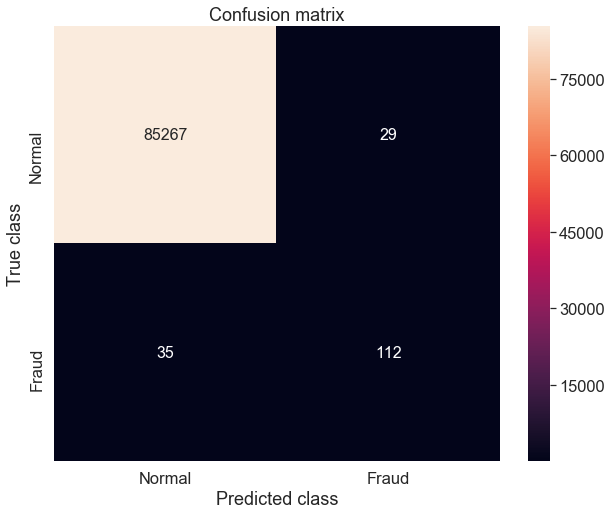

In [355]:
#confusion matrix of knn(n=200)+undersampling
conf_matrix = confusion_matrix(ytest, y_pred,labels=[0,1])
cm = pd.DataFrame(conf_matrix, index=[0,1], columns=[0,1])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d",annot_kws={"size": 16});
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [325]:
rus = RandomUnderSampler(random_state=42)
X_re, y_re = rus.fit_resample(Xtrain, ytrain)
for i in [300, 400, 500, 600]:
    
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_re, y_re)

    y_pred = knn.predict(Xtest)
    rec = recall_score(ytest, y_pred)
    f = f1_score(ytest, y_pred)

    print ("n_neighbors: {} Recall: {} F-score: {}".format(i, round(rec,3), round(f,3)))

n_neighbors: 300 Recall: 0.687 F-score: 0.745
n_neighbors: 400 Recall: 0.578 F-score: 0.672
n_neighbors: 500 Recall: 0.415 F-score: 0.537
n_neighbors: 600 Recall: 0.293 F-score: 0.417


##### Oversampling
I interrupted running the cell below due to overtime.

In [114]:
smote = SMOTE(random_state=0)
X_re, y_re = smote.fit_resample(Xtrain, ytrain)

for i in [10, 20, 30, 40]:
    
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_re, y_re)

    y_pred = knn.predict(Xtest)
    rec = recall_score(ytest, y_pred)
    f = f1_score(ytest, y_pred)

    print ("n_neighbors: {} Recall: {} F-score: {}".format(i, round(rec,3), round(f,3)))
    



KeyboardInterrupt: 

#### 6. Decision Tree

In [115]:
from sklearn.tree import DecisionTreeClassifier

##### Undersampling

In [124]:
param = {'max_depth':[5,10,15,20], 'max_features':[3,5,7,10], 'max_leaf_nodes':[50, 100, 150, 200]}

In [127]:
rus = RandomUnderSampler(random_state=0)
X_re, y_re = rus.fit_resample(Xtrain, ytrain)

dt = DecisionTreeClassifier(random_state=0)
gsc = GridSearchCV(dt, param, scoring='recall')

In [128]:
gsc.fit(X_re, y_re)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid=[{'max_depth': [5, 10, 15, 20],
                          'max_features': [3, 5, 7, 10],
                          'max_leaf_nodes': [50, 100, 150, 200]}],
             scoring='recall')

In [129]:
gsc.best_params_

{'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': 50}

In [130]:
gsc.best_score_

0.9014492753623189

In [211]:
dt_u = DecisionTreeClassifier(max_depth=10, max_features=10, max_leaf_nodes=50, random_state=0)

dt_u.fit(X_re, y_re)

y_pred = dt_u.predict(Xtest)
rec_dt_u = recall_score(ytest, y_pred)
f_dt_u = f1_score(ytest, y_pred)

print ("Recall: {}".format(round(rec_dt_u,3)))
print ("F-score: {}".format(round(f_dt_u,3)))

Recall: 0.884
F-score: 0.09


##### Oversampling

In [212]:
smote = SMOTE(random_state=0)
X_re, y_re = smote.fit_resample(Xtrain, ytrain)

dt_sm = DecisionTreeClassifier(random_state=0)

dt_sm.fit(X_re, y_re)

y_pred = dt_sm.predict(Xtest)
rec_dt_sm = recall_score(ytest, y_pred)
f_dt_sm = f1_score(ytest, y_pred)

print ("Recall: {}".format(round(rec_dt_sm,3)))
print ("F-score: {}".format(round(f_dt_sm,3)))

Recall: 0.776
F-score: 0.5


#### 7. Autoencoder

In [135]:
from tensorflow import keras
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


Autoencoder is a neural network which does the job to filter out noise by encoding and decoding data. In this way, anomalies have higher reconstruction errors which makes it easy for detection.

In [174]:
smote = SMOTE(random_state=0)
X_re, y_re = smote.fit_resample(Xtrain, ytrain)

X_train, X_valid, y_train, y_valid = train_test_split(X_re, y_re, test_size=0.3) 

In [175]:
X_train = X_train.values

In [162]:
input_dim = X.shape[1]
def create_autoencoder(encoding_dim):
    
    autoencoder = keras.models.Sequential()
    
    autoencoder.add(keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim,)))
    autoencoder.add(keras.layers.Dense(encoding_dim, activation='tanh'))      
    autoencoder.add(keras.layers.Dense(int(encoding_dim/2), activation='relu'))     
    autoencoder.add(keras.layers.Dense(encoding_dim, activation='tanh'))      
    autoencoder.add(keras.layers.Dense(input_dim, activation='relu'))         
    autoencoder.compile(optimizer='adam', 
                        loss='mean_squared_error', 
                        metrics=['accuracy'])
    return autoencoder

In [164]:
auto = create_autoencoder(16)
auto.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 29)                870       
_________________________________________________________________
dense_30 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_32 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_33 (Dense)             (None, 29)                493       
Total params: 2,123
Trainable params: 2,123
Non-trainable params: 0
_________________________________________________________________


In [176]:
history = auto.fit(X_train, X_train, 
                 shuffle = True,
                 batch_size = 256,
                 epochs=50,
                 validation_data=(X_valid, X_valid)).history

Train on 278626 samples, validate on 119412 samples
Epoch 1/50
278626/278626 [==============================] - 10s 35us/sample - loss: 12.4897 - acc: 0.3676 - val_loss: 12.0437 - val_acc: 0.4787
Epoch 2/50
278626/278626 [==============================] - 10s 35us/sample - loss: 12.0686 - acc: 0.5221 - val_loss: 11.8924 - val_acc: 0.5542
Epoch 3/50
278626/278626 [==============================] - 10s 35us/sample - loss: 11.9825 - acc: 0.5730 - val_loss: 11.8468 - val_acc: 0.5907
Epoch 4/50
278626/278626 [==============================] - 10s 35us/sample - loss: 11.9490 - acc: 0.6132 - val_loss: 11.8252 - val_acc: 0.6366
Epoch 5/50
278626/278626 [==============================] - 9s 32us/sample - loss: 11.9320 - acc: 0.6481 - val_loss: 11.8123 - val_acc: 0.6611
Epoch 6/50
278626/278626 [==============================] - 9s 31us/sample - loss: 11.9209 - acc: 0.6740 - val_loss: 11.8032 - val_acc: 0.6824
Epoch 7/50
278626/278626 [==============================] - 10s 35us/sample - loss: 11

{'loss': [12.489722961905846,
  12.068556675048375,
  11.98252632152915,
  11.94900648229702,
  11.931992870629085,
  11.920909221742242,
  11.913999895062952,
  11.908702423391595,
  11.901326708816129,
  11.895735433837157,
  11.892210380111319,
  11.889019794308991,
  11.887423326108781,
  11.885149465779163,
  11.883564721599042,
  11.88212728718397,
  11.880928279302532,
  11.875524184730063,
  11.862772596272356,
  11.860700954246045,
  11.859528537389155,
  11.858501602281779,
  11.85726274810167,
  11.85651223238668,
  11.85556504024621,
  11.853405979075964,
  11.851537638154916,
  11.849978196995137,
  11.847908165439582,
  11.845820161970156,
  11.845027624050033,
  11.844214265624611,
  11.843122692793667,
  11.84267001910423,
  11.842490918057205,
  11.842208238948768,
  11.84126752079011,
  11.841019655302018,
  11.840559455490038,
  11.840527887749548,
  11.83982655172244,
  11.839054622109211,
  11.838843575337725,
  11.838299485633266,
  11.838466300927937,
  11.837999

Reconstruct data and decide threshold.

In [248]:
X_pred = auto.predict(X_train)

In [249]:
mse = np.mean(np.square(X_pred-X_train), axis=1)
pred = pd.DataFrame({'error':mse, 'Class':y_train.values})

In [250]:
pred.groupby('Class').describe()

error                                                      \
          count       mean        std       min       25%       50%   
Class                                                                 
0      139496.0   0.698503   4.682406  0.039977  0.274876  0.423136   
1      139130.0  23.006523  33.499711  0.090914  3.398641  7.883216   

                               
             75%          max  
Class                          
0       0.633793  1459.726759  
1      22.887977   248.604963

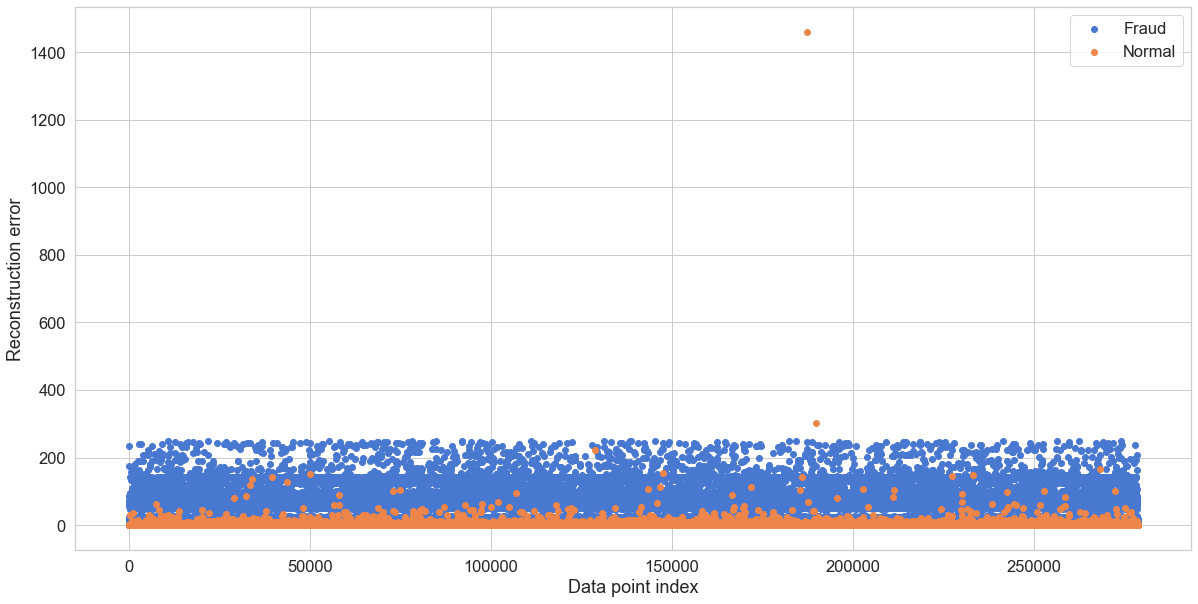

In [251]:
plt.figure(figsize=(20,10))
plt.scatter(pred[pred['Class']==1].index, pred[pred['Class']==1].error, label = 'Fraud')
plt.scatter(pred[pred['Class']==0].index, pred[pred['Class']==0].error, label = 'Normal')
plt.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Take 3.3, a little smaller than the first quartile of fraud construction error, as threshold.

In [252]:
y_pred = [1 if e > 3.3 else 0 for e in pred['error'].values]

In [253]:
rec = recall_score(y_train, y_pred)
f = f1_score(y_train, y_pred)

print ("Recall: {}".format(round(rec,3)))
print ("F-score: {}".format(round(f,3)))

Recall: 0.771
F-score: 0.862


Apply autoencoder to predict test data.

In [356]:
X_pred = auto.predict(Xtest)

In [357]:
mse = np.mean(np.square(X_pred-Xtest), axis=1)
pred_auto = pd.DataFrame({'error':mse, 'Class':ytest.values})
y_pred = [1 if e > 3.3 else 0 for e in pred_auto['error'].values]

In [321]:
rec_auto = recall_score(ytest, y_pred)
f_auto = f1_score(ytest, y_pred)

print ("Recall: {}".format(round(rec_auto,3)))
print ("F-score: {}".format(round(f_auto,3)))

Recall: 0.755
F-score: 0.125


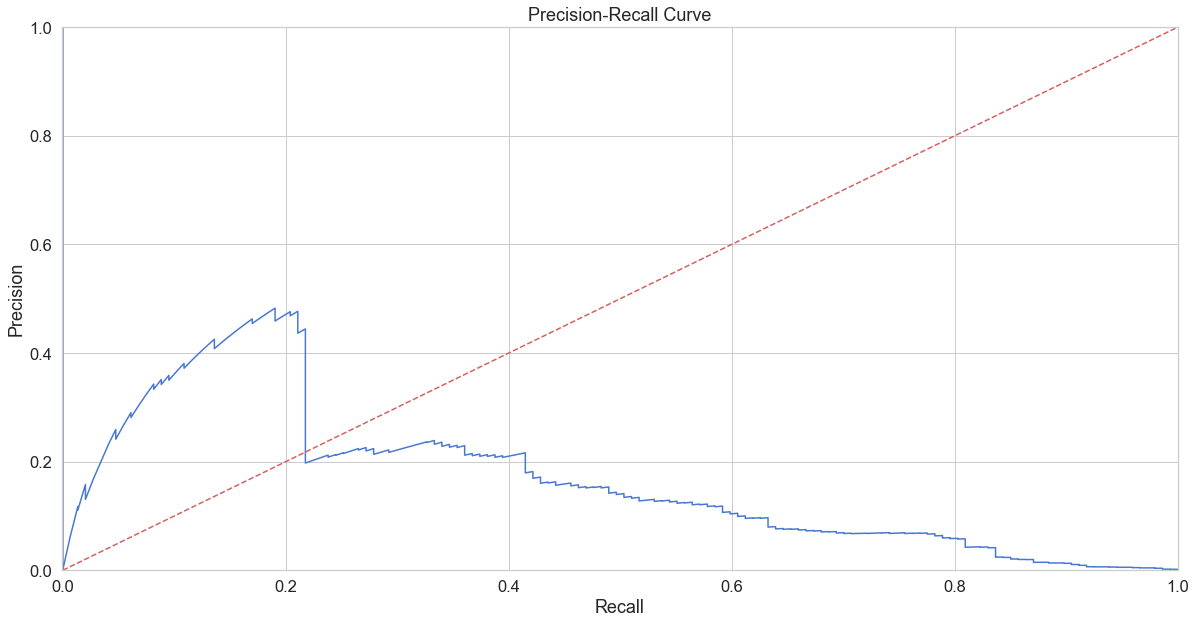

In [322]:
precision, recall, thresholds = precision_recall_curve(pred_auto.Class, pred_auto.error)

plt.figure(figsize=(20,10))
plt.title('Precision-Recall Curve')
plt.plot(recall, precision)
#plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

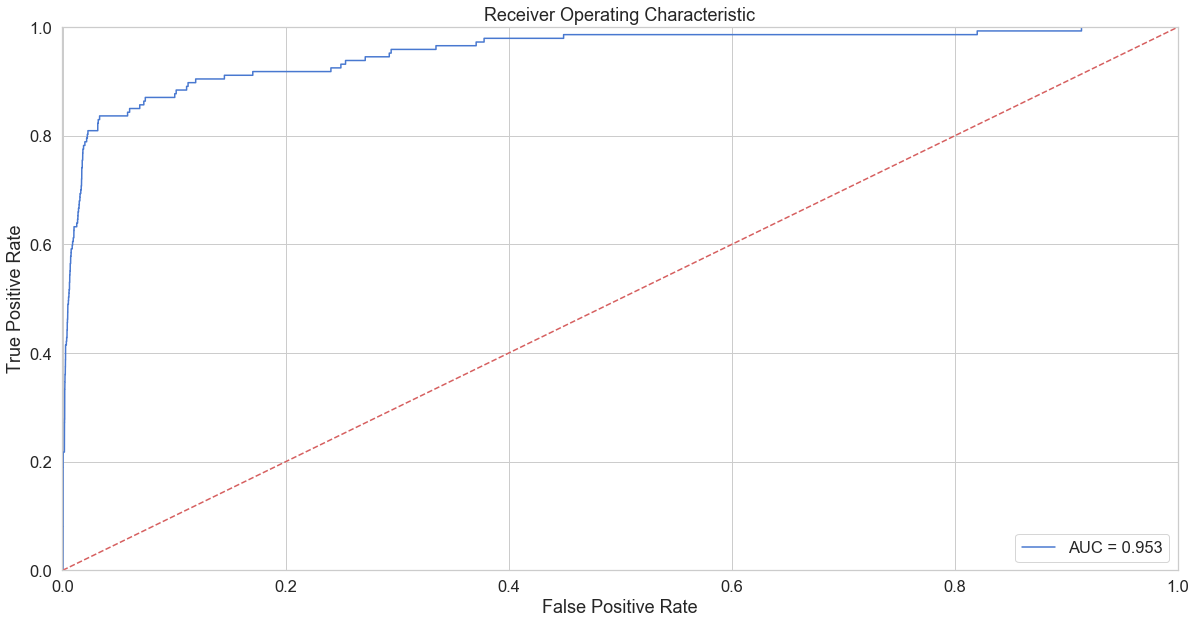

In [245]:
fpr, tpr, thresholds = roc_curve(pred_auto.Class, pred_auto.error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(20,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

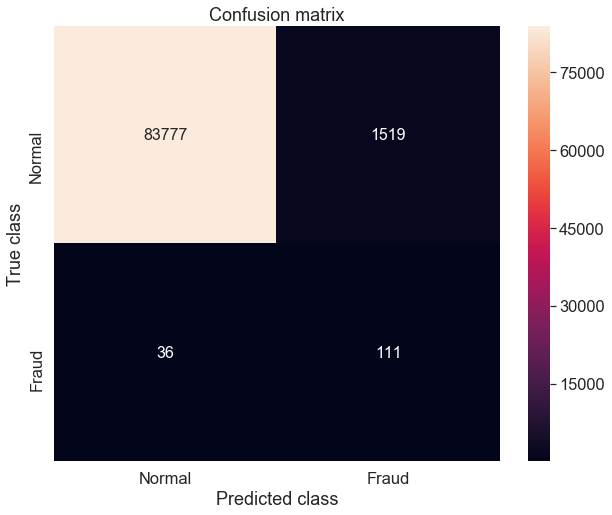

In [358]:
conf_matrix = confusion_matrix(pred_auto.Class, y_pred,labels=np.unique(pred_auto.Class))
cm = pd.DataFrame(conf_matrix, index=np.unique(pred_auto.Class), columns=np.unique(pred_auto.Class))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d",annot_kws={"size": 16});
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Generally speaking, knn with undersampling showed the best performance in terms of precision, recall and f-score on test data.

However, I didn't perform a finer tuning on logistic regression, decision tree, and autoencoder, which may predict test data with better performance. I would like to try a fine tuning and other sampling methods to improve model later.